# Deep Neural Network for Image Classification: Application

You will use the functions you'd implemented in the Part 1 of the assignment to build a deep network, and apply it to cat vs non-cat classification. Hopefully, you will see an improvement in accuracy relative to your previous logistic regression implementation.  

**After this assignment you will be able to:**
- Build and apply a deep neural network to supervised learning. 

Let's get started!

## 1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- dnn_app_utils provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
#from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - Dataset

You will use the same "Cat vs non-Cat" dataset as in "Logistic Regression" Assignment (Assignment 1). The model you had built had 70% test accuracy on classifying cats vs non-cats images. Hopefully, your new model will perform a better!

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labelled as cat (1) or non-cat (0)
    - a test set of m_test images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [2]:
def load_data():
    train_dataset = h5py.File('../../data/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('../../data/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a non-cat picture.


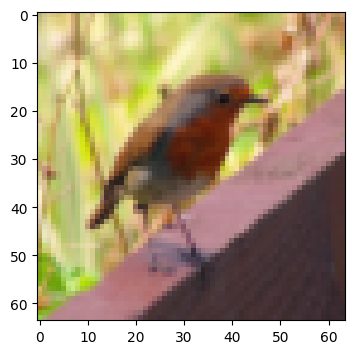

In [4]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [5]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

**Exercise 1**:  Flattern and array the samples in columns

In [6]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T  # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ equals $64 \times 64 \times 3$ which is the size of one reshaped image vector.

## 3 - Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

You will build two different models:
- A 2-layer neural network
- An L-layer deep neural network

You will then compare the performance of these models, and also try out different values for $L$. 

Let's look at the two architectures.

### 3.1 - 2-layer neural network

<img src="2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: 2-layer neural network. <br>

The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You then repeat the same process.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias). 
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.

### 3.2 - L-layer deep neural network

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br>

The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

### 3.3 - General methodology

As usual you will follow the Deep Learning methodology to build the model:
1. Initialize parameters / Define hyperparameters
2. Loop for num_iterations:

    a. Forward propagation

    b. Compute cost function

    c. Backward propagation
    
    d. Update parameters (using parameters, and grads from backprop) 
    
4. Use trained parameters to predict labels

Let's now implement those two models!

## 4 - Two-layer neural network

**Exercise 2**:  Use the helper functions you have implemented in the previous assignment to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [7]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [8]:
def linear_activation_forward(A_prev, W, b, activation):
    def linear_forward(A, W, b):
        """
        Implement the linear part of a layer's forward propagation.

        Arguments:
        A -- activations from previous layer (or input data): (size of previous layer, number of examples)
        W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
        b -- bias vector, numpy array of shape (size of the current layer, 1)

        Returns:
        Z -- the input of the activation function, also called pre-activation parameter 
        cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
        """
        
        ### START CODE HERE ###
        Z = np.dot(W, A) + b    
        ### END CODE HERE ###
        
        assert(Z.shape == (W.shape[0], A.shape[1]))
        cache = (A, W, b)
        
        return Z, cache
    
    def sigmoid(Z):
        """
        Implements the sigmoid activation in numpy
        
        Arguments:
        Z -- numpy array of any shape
        
        Returns:
        A -- output of sigmoid(z), same shape as Z
        cache -- returns Z as well, useful during backpropagation
        """
        
        A = 1/(1+np.exp(-Z))
        cache = Z
        
        return A, cache
    
    def relu(Z):
        """
        Implement the RELU function.
        Arguments:
        Z -- Output of the linear layer, of any shape
        Returns:
        A -- Post-activation parameter, of the same shape as Z
        cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
        """
        
        A = np.maximum(0,Z)
        
        assert(A.shape == Z.shape)
        
        cache = Z 
        return A, cache

    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
            stored for computing the backward pass efficiently
    """
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### 
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        ### END CODE HERE ###
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        ### END CODE HERE ###
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [9]:
# GRADED FUNCTION: two_layer_model
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### 
    def initialize_parameters(n_x, n_h, n_y):
        """
        Argument:
        n_x -- size of the input layer
        n_h -- size of the hidden layer
        n_y -- size of the output layer
        
        Returns:
        parameters -- python dictionary containing your parameters:
                        W1 -- weight matrix of shape (n_h, n_x)
                        b1 -- bias vector of shape (n_h, 1)
                        W2 -- weight matrix of shape (n_y, n_h)
                        b2 -- bias vector of shape (n_y, 1)
        """
        np.random.seed(1)
        W1 = np.random.randn(n_h, n_x)*0.01
        b1 = np.zeros((n_h, 1))
        W2 = np.random.randn(n_y, n_h)*0.01
        b2 = np.zeros((n_y, 1))
        assert(W1.shape == (n_h, n_x))
        assert(b1.shape == (n_h, 1))
        assert(W2.shape == (n_y, n_h))
        assert(b2.shape == (n_y, 1))
        parameters = {"W1": W1,
                    "b1": b1,
                    "W2": W2,
                    "b2": b2}
        return parameters    
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    def compute_cost(AL, Y):
        """
        Arguments:
        AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
        Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

        Returns:
        cost -- cross-entropy cost
        """
        
        m = Y.shape[1]
        # Compute loss from aL and y.
        ### START CODE HERE ### 
        cost = -np.sum((Y * np.log(AL) + (1 - Y) * np.log(1 - AL)))/m    
        ### END CODE HERE ###
        
        cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
        assert(cost.shape == ())
        
        return cost
    
    def linear_activation_backward(dA, cache, activation):
        def linear_backward(dZ, cache):
            """
            Implement the linear portion of backward propagation for a single layer (layer l)

            Arguments:
            dZ -- Gradient of the cost with respect to the linear output (of current layer l)
            cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

            Returns:
            dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
            dW -- Gradient of the cost with respect to W (current layer l), same shape as W
            db -- Gradient of the cost with respect to b (current layer l), same shape as b
            """
            A_prev, W, b = cache
            m = A_prev.shape[1]
            ### START CODE HERE ###
            dA_prev = np.dot(W.T, dZ)
            dW = np.dot(dZ, A_prev.T) / m
            db = np.reshape(np.sum(dZ, axis = 1) / m, b.shape)
            ### END CODE HERE ###

            assert (dA_prev.shape == A_prev.shape)
            assert (dW.shape == W.shape)
            assert (db.shape == b.shape)

            return dA_prev, dW, db

        def relu_backward(dA, cache):
            """
            Implement the backward propagation for a single RELU unit.
            Arguments:
            dA -- post-activation gradient, of any shape
            cache -- 'Z' where we store for computing backward propagation efficiently
            Returns:
            dZ -- Gradient of the cost with respect to Z
            """
            
            Z = cache
            dZ = np.array(dA, copy=True) # just converting dz to a correct object.
            
            # When z <= 0, you should set dz to 0 as well. 
            dZ[Z <= 0] = 0
            
            assert (dZ.shape == Z.shape)
            
            return dZ    
        
        def sigmoid_backward(dA, cache):
            """
            Implement the backward propagation for a single SIGMOID unit.
            Arguments:
            dA -- post-activation gradient, of any shape
            cache -- 'Z' where we store for computing backward propagation efficiently
            Returns:
            dZ -- Gradient of the cost with respect to Z
            """
            
            Z = cache
            
            s = 1/(1+np.exp(-Z))
            dZ = dA * s * (1-s)
            
            assert (dZ.shape == Z.shape)
            
            return dZ

        """
        Implement the backward propagation for the LINEAR->ACTIVATION layer.
        
        Arguments:
        dA -- post-activation gradient for current layer l 
        cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
        activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
        
        Returns:
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        db -- Gradient of the cost with respect to b (current layer l), same shape as b
        """
        linear_cache, activation_cache = cache
        
        if activation == "relu":
            ### START CODE HERE ### 
            dZ = relu_backward(dA, activation_cache)
            dA_prev, dW, db = linear_backward(dZ, linear_cache)
            ### END CODE HERE ###
            
        elif activation == "sigmoid":
            ### START CODE HERE ### 
            dZ = sigmoid_backward(dA, activation_cache)
            dA_prev, dW, db = linear_backward(dZ, linear_cache)
            ### END CODE HERE ###
        
        return dA_prev, dW, db
    
    def update_parameters(parameters, grads, learning_rate):
        """
        Update parameters using gradient descent
        
        Arguments:
        parameters -- python dictionary containing your parameters 
        grads -- python dictionary containing your gradients, output of L_model_backward
        
        Returns:
        parameters -- python dictionary containing your updated parameters 
                    parameters["W" + str(l)] = ... 
                    parameters["b" + str(l)] = ...
        """
        
        L = len(parameters) // 2 # number of layers in the neural network

        # Update rule for each parameter. Use a for loop.
        ### START CODE HERE ### 
        for l in range(L):
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
        ### END CODE HERE ###
        return parameters
    
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### 
        cost = compute_cost(A2, Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### 
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### 
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Run the cell below to train your parameters. See if your model runs. The cost should be decreasing. It may take up to 5 minutes to run 2500 iterations. Check if the "Cost after iteration 0" matches the expected output below, if not click on the square (⬛) on the upper bar of the notebook to stop the cell and try to find your error.

Cost after iteration 0: 0.6930497356599891
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.4754901313943326
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.400797753620389
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.30527536361962637
Cost after iteration 1200: 0.27491377282130197
Cost after iteration 1300: 0.24681768210614835
Cost after iteration 1400: 0.19850735037466116
Cost after iteration 1500: 0.17448318112556643
Cost after iteration 1600: 0.17080762978095307
Cost after iteration 1700: 0.11306524562164758
Cost after iteration 1800: 0.09629426845937161
Cost after iteration 1900: 0.0834261795972686
Cost after iteration 2000: 0.07439078704319077
Cost after iteration 2100: 0.0663074813

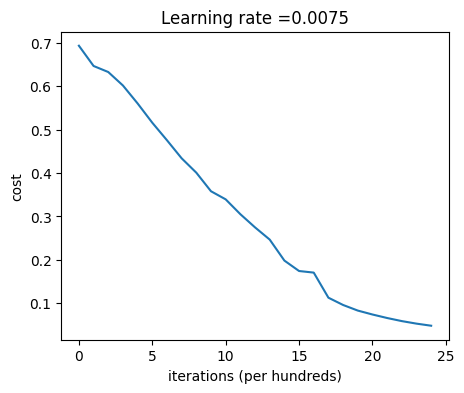

In [10]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

**Expected Output**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.69... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.64... </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.04... </td>
    </tr>
</table>

Good thing you built a vectorized implementation! Otherwise it might have taken 10 times longer to train this.

Now, you can use the trained parameters to classify images from the dataset. To see your predictions on the training and test sets, run the cell below.

In [11]:
def predict(X, y, parameters):
    m = X.shape[1]
    A1, _ = linear_activation_forward(X, parameters['W1'], parameters['b1'], "relu")
    p, _ = linear_activation_forward(A1, parameters['W2'], parameters['b2'], "sigmoid")
    p = np.where(p >= 0.5, 1, 0)
    p = np.reshape(p, y.shape)
    print("Accuracy: "  + str(np.sum((p == y))/m))
    return p
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 1.0


**Expected Output**:
<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 1.0 </td>
    </tr>
</table>

In [12]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


**Expected Output**:

<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 0.72 </td>
    </tr>
</table>

**Note**: You may notice that running the model on fewer iterations (say 1500) gives better accuracy on the test set. This is called "early stopping" and we will talk about it in the next course. Early stopping is a way to prevent overfitting. 

Congratulations! It seems that your 2-layer neural network has better performance (72%) than the logistic regression implementation (70%, assignment week 2). Let's see if you can do even better with an $L$-layer model.

## 5 - L-layer Neural Network

**Exercise 3**: Use the helper functions you have implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [13]:
### CONSTANTS ###
layers_dims = [12288, 20, 20, 10, 5, 1] #  4-layer model

In [14]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. 
    ### START CODE HERE ###
    parameters = None
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, None):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### 
        AL, caches = None
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### 
        cost = None
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### 
        grads = None
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### 
        parameters = None
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

You will now train the model as a 4-layer neural network. 

Run the cell below to train your model. The cost should decrease on every iteration. It may take up to 5 minutes to run 2500 iterations. Check if the "Cost after iteration 0" matches the expected output below, if not click on the square (⬛) on the upper bar of the notebook to stop the cell and try to find your error.

In [15]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

TypeError: 'NoneType' object cannot be interpreted as an integer

**Expected Output**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.69... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.66... </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.003... </td>
    </tr>
</table>

In [ ]:
pred_train = predict(train_x, train_y, parameters)

<table>
    <tr>
    <td>
    **Train Accuracy**
    </td>
    <td>
    greater than 0.95
    </td>
    </tr>
</table>

In [ ]:
pred_test = predict(test_x, test_y, parameters)

**Expected Output**:

<table> 
    <tr>
        <td> **Test Accuracy**</td>
        <td> greater than 0.7 </td>
    </tr>
</table>

Congrats! It seems that your 4-layer neural network has better performance (80%) than your 2-layer neural network (72%) on the same test set. 

This is good performance for this task. Nice job!  

##  6) Results Analysis

First, let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images.

In [ ]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

# 7 - Test with your own data (12 additional points) ##

Use the dataset of fingerprints created in Assignment 2 and test the previously implemented classifier. Note that this is a two-class problem, so if your dataset has three or more classes, select two.

Report a pdf file in Moodle where you discuss:
- Compare the results obtained with logistic regression and the Deep Network implemented in this assignment. (6 points)
- Test several iterations, learning rates, number of hidden layers and units, and discuss the results. (6 points)